In [1]:
from collections import namedtuple
import warnings

import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

from pyuoi.UoI_Lasso import UoI_Lasso

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning, # targets FutureWarnings from sklearn
                        module="sklearn")  
warnings.filterwarnings("ignore", category=RuntimeWarning, # targets a RuntimeWarning about LAPACK
                        message="internal gelsd driver lwork query error")  

%matplotlib inline

plt.style.use('ggplot')

np.random.seed(42)

This notebook demonstrates $UoI$ and `pyuoi` in action by applying $UoI_{Lasso}$ to synthetic data.

$UoI$ is a framework for combining sparse model selection, via an intersection operation, with model estimation, via a union operation. For more details, see [the NIPS 2017 paper](https://papers.nips.cc/paper/6708-union-of-intersections-uoi-for-interpretable-data-driven-discovery-and-prediction). Different choices of intersection and union operations give rise to different concrete $UoI$ algorithms, denoted by $UoI_{XYZ}$.

`pyuoi` implements several algorithms in the $UoI$ framework using the `sklearn` API.

This notebook shows the `pyuoi.UoI_Lasso` implementation of the $UoI_{Lasso}$ algorithm, which chooses the Lasso algorithm as its intersection, or model selection, operation, and bagging as its union operation.

This algorithm does not have an explicit prior over the parameters, but it assumes that the response vector $y$ can be well-described as a linear function $\beta$ of the data $x$ plus Gaussian-distributed noise $\epsilon$:

$$
y \sim \beta^\top x + \epsilon \\
\epsilon \sim \mathcal{N}(0, \sigma^2)
$$

It is most effective relative to other algorithms when $\beta$ is _sparse_ in the $\ell_0$ sense: when some fraction of the "true" values of $\beta$ are exactly equal to $0$. The problem of choosing which variables should be non-zero is an example of a _model selection_ problem.

A distribution with some values exactly equal to $0$ and some drawn from a different distribution is known as a _spike-and-slab distribution_. Because $UoI$ is designed to be relatively insensitive to the true distribution of the parameters, we explicitly allow, in this example, the generation of parameters with arbitrary distributions for the slab.

The function `generate_model_and_data` below generates a true model and data according to the description above, with the distribution of non-zero parameters set by the `param_sampler` argument.

In [3]:
def generate_model_and_data(n_samples, n_features, num_nonzero, noise_scale, param_sampler=np.random.laplace):
    # create design matrix
    X = np.random.normal(size=(n_samples, n_features))
    
    # sample model parameters
    beta = np.zeros(shape=(n_features, 1))
    nonzero_idx = np.random.choice(np.arange(n_features), num_nonzero, replace=False)
    beta[nonzero_idx, 0] = param_sampler(size=(num_nonzero))
    
    # sample noise
    noise = np.random.normal(scale=noise_scale, size=(n_samples, 1))
    
    # generate response vector
    y = np.dot(X, beta) + noise
    
    return X, y, beta

To check model performance, we calculate and report the following metrics on the fit:
- False Positive Rate: the fraction of parameters incorrectly selected.
- False Negative Rate: the fraction of parameters incorrectly not selected.
- (Relative) Bias: the ratio of the observed difference between true and estimated parameters to the $\ell_1$ norm of the true parameters (the sum of absolute values).

We further plot the true and recovered values of the parameters against each other.

The functions in the cell below calculate and display these metrics.

In [4]:
FitMetrics = namedtuple("FitMetrics",
                        ["false_positive_rate", "false_negative_rate", "bias"])

def calculate_fit_metrics(estimate, true):
    false_positive_rate = np.count_nonzero(estimate[true == 0]) / len(true)
    false_negative_rate = np.count_nonzero(true[estimate == 0]) / len(true)
    relative_bias = (estimate - true) / np.sum(np.abs(true))
    
    return FitMetrics(false_positive_rate, false_negative_rate, relative_bias)

def display_results_and_metrics(estimate, true, metrics):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(true, estimate)
    ax.plot(ax.get_xlim(), ax.get_xlim(), linewidth=3)
    ax.set_xlabel('True', fontsize=25)
    ax.set_ylabel('Estimates', fontsize=25)
    
    print('False Positive Rate: ', metrics.false_positive_rate)
    print('False Negative Rate: {}'.format(metrics.false_negative_rate))
    print('Relative Bias: {:.4f}'.format(np.mean(metrics.bias)))
    plt.show()

These functions are collected under `basic_test` below.

In [5]:
def basic_test(n_features=10, n_samples=50, noise_scale=0.5, sparsity=0.,
               param_sampler=np.random.laplace,
               stratify=np.ones(10)):
    """Tests UoI Lasso on synthetic data and reports performance metrics on the fit.
    
    Data is sampled from a linear model with Gaussian error and parameters
    from a spike-and-slab distribution. Spike height is determined by the
    sparsity parameter; the slab is sampled from by param_sampler.
    
    Parameters
    ----------
    n_features : int
        Number of data features.
        
    n_samples : int
        Number of data points to sample.
        
    noise_scale : float
        Standard deviation of noise. Data has unit variance.
        
    sparsity: float
        Ratio of parameters that are exactly 0.
        
    param_sampler: callable
        Callable that returns a numpy array of values with shape (sz,)
        when called with argument size=sz.
        
    stratify: array-like or None, default None
        Ensures groups of samples are alloted to training/test sets
        proportionally. Labels for each group must be an int greater
        than zero. Must be of size equal to the number of samples, with
        further restrictions on the number of groups.
    
    Returns
    -------
    uoi : UoI_Lasso
        The fit UoI Lasso model.
        
    X : ndarray, shape (n_samples, n_features)
        The design matrix for the synthetic data.
        
    y : ndarray, shape (n_samples,)
        Response vector for the synthetic data.
        
    fit_metrics : FitMetrics
        Namedtuple containing metrics on UoI Lasso's fit: false postive
        and negative rate and average parameter value bias.
    """
    # calculate number of nonzero parameters
    num_nonzero = int((1 - sparsity) * n_features)
    
    # generate data according to a known (random) underlying model
    X, y, beta = generate_model_and_data(n_samples, n_features, num_nonzero,
                                         noise_scale, param_sampler)
       
    # run UoI Lasso
    uoi = UoI_Lasso()
    uoi.fit(X, y, stratify=stratify)
    
    # compute metrics
    estimate, true = uoi.coef_, beta.ravel()
    fit_metrics = calculate_fit_metrics(estimate, true)
    
    # display results
    display_results_and_metrics(estimate, true, fit_metrics)
    
    return uoi, X, y, beta, fit_metrics

False Positive Rate:  0.1
False Negative Rate: 0.1
Relative Bias: 0.0010


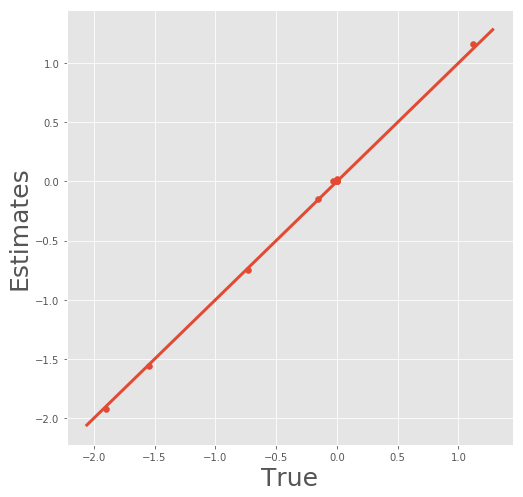

In [6]:
uoi, X, y, beta, fit_metrics = basic_test(n_features=10, n_samples=400, sparsity=0.4,
                                    stratify=np.concatenate((np.ones(200), 2*np.ones(200))),
                                    param_sampler=np.random.laplace)